In [2]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.metrics import accuracy_score, f1_score, precision_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
import seaborn as sns

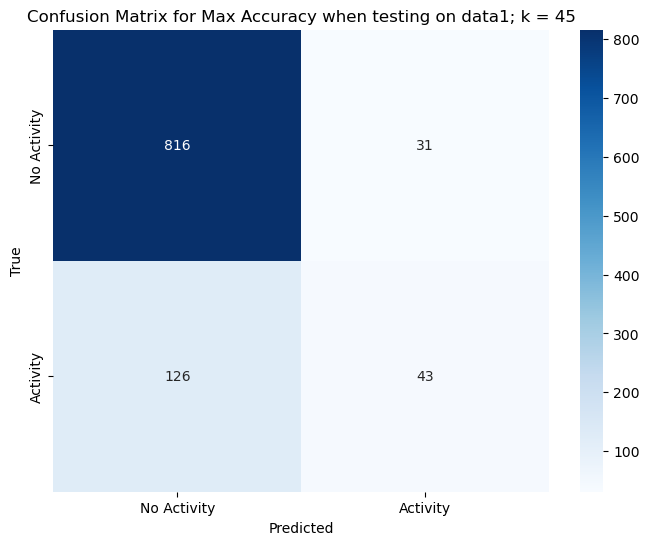

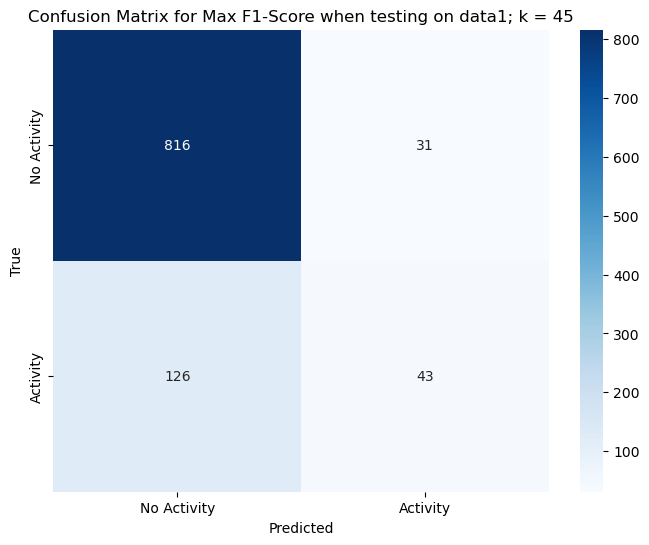

data1 has been tested on everyone


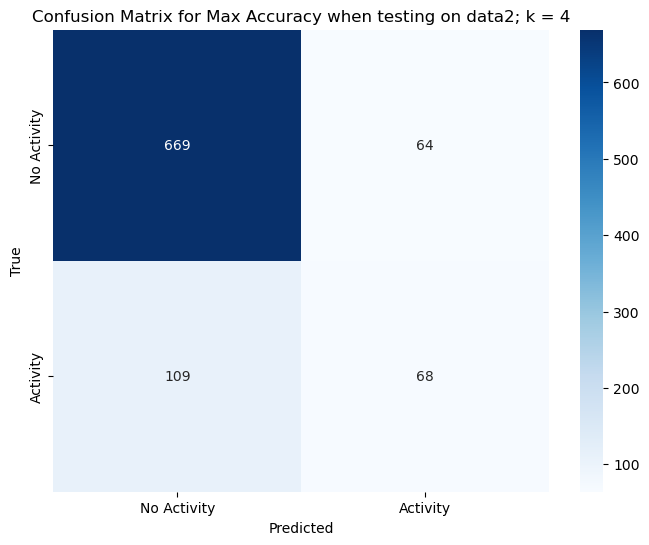

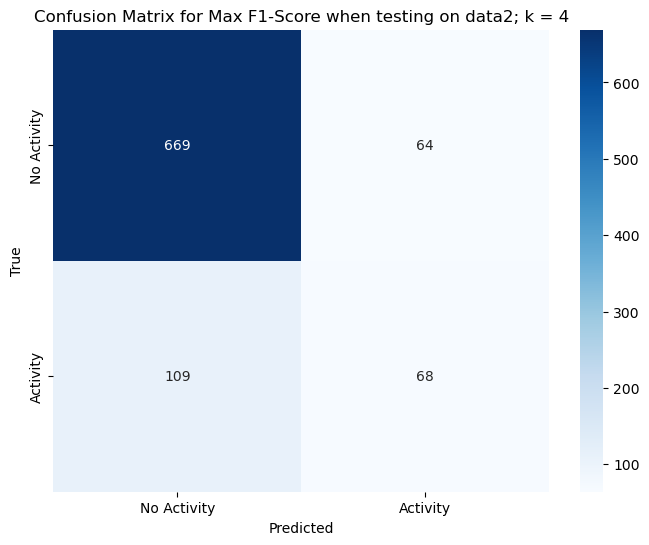

data2 has been tested on everyone


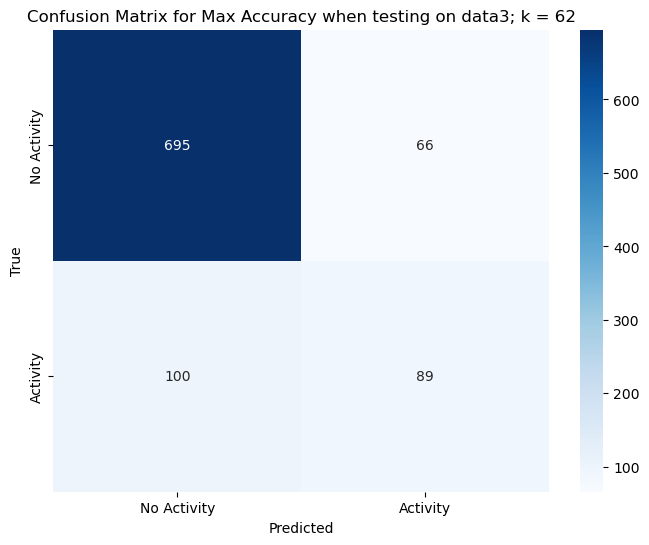

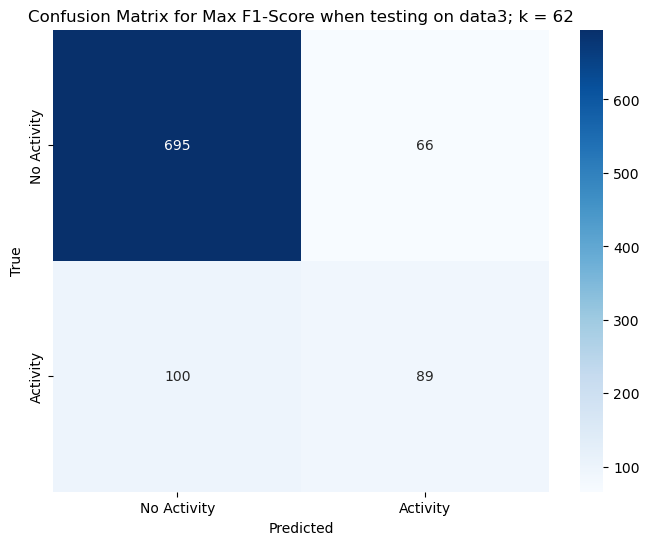

data3 has been tested on everyone


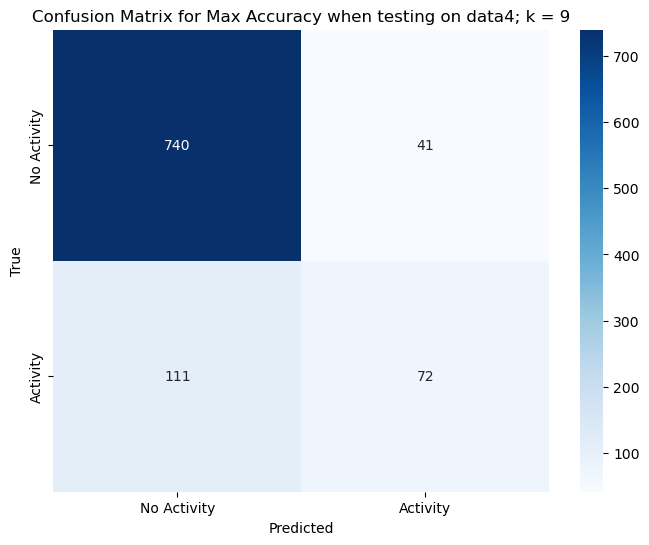

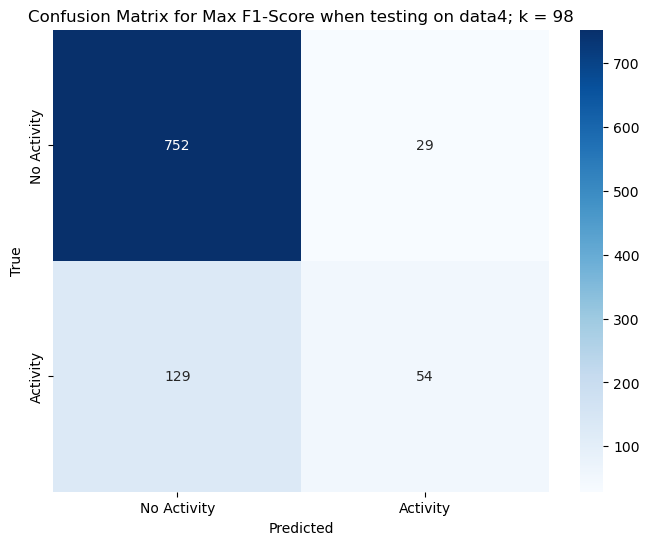

data4 has been tested on everyone


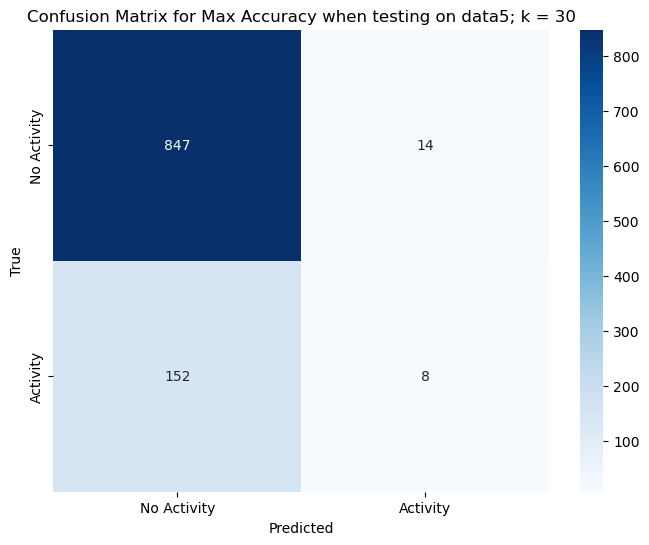

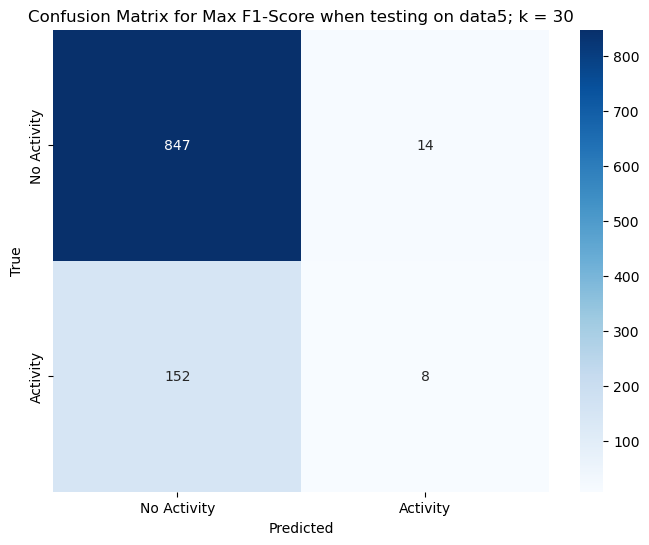

data5 has been tested on everyone


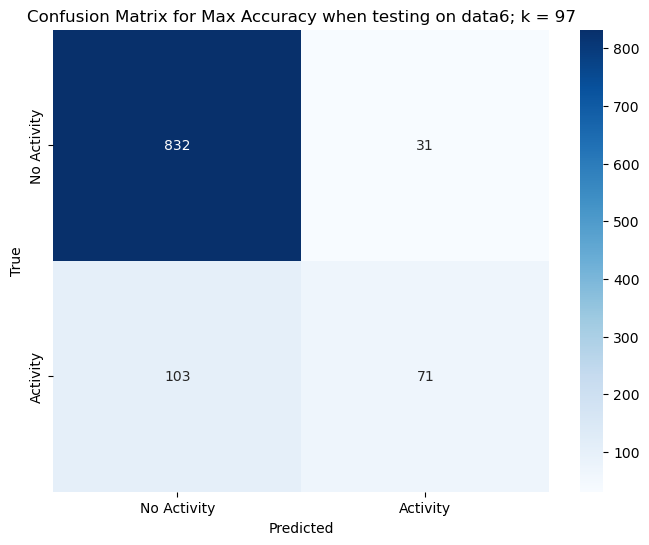

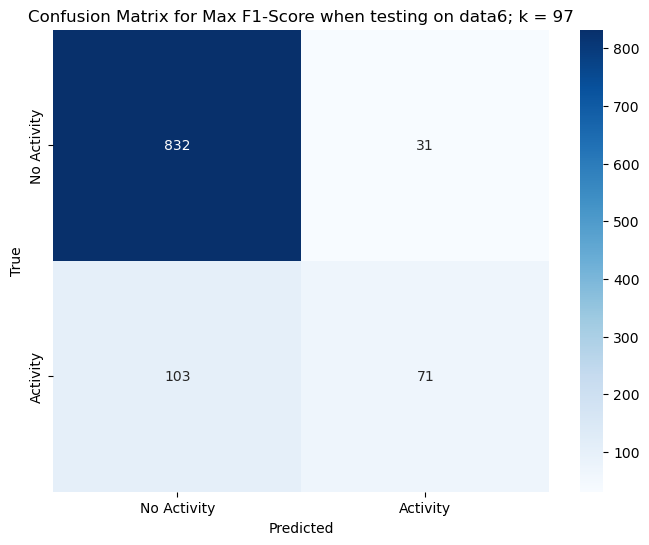

data6 has been tested on everyone


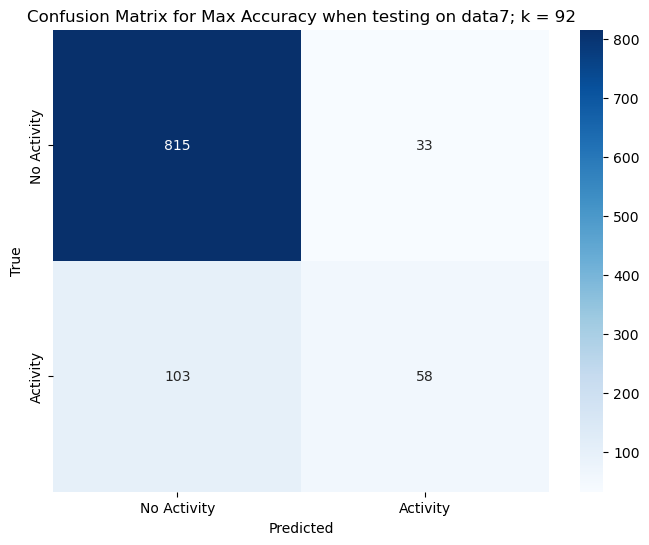

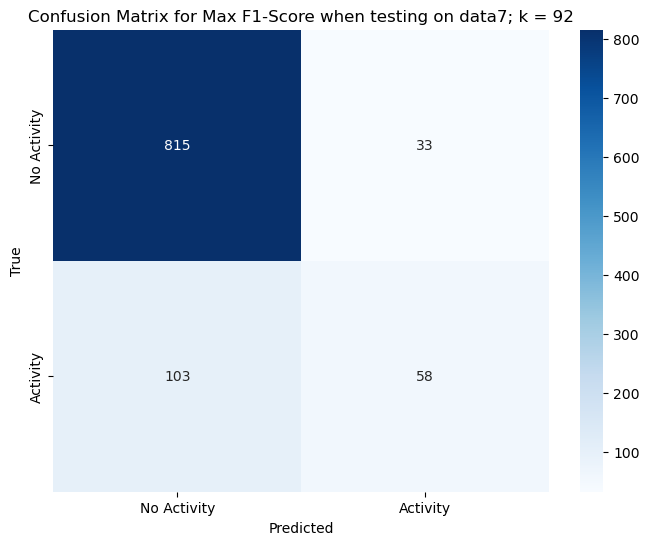

data7 has been tested on everyone


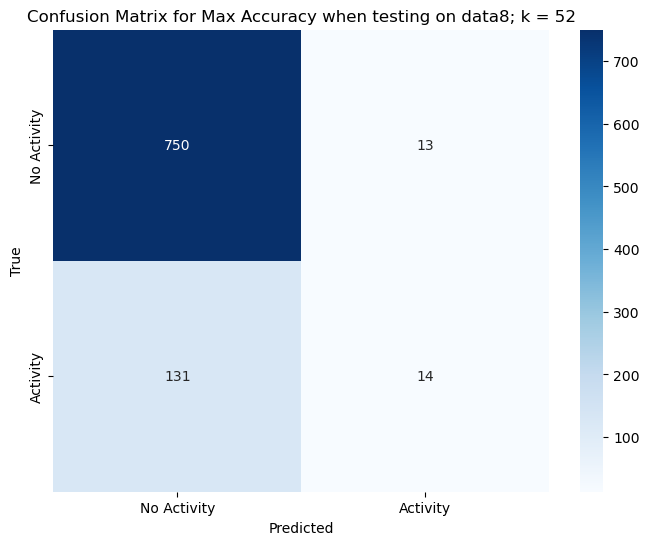

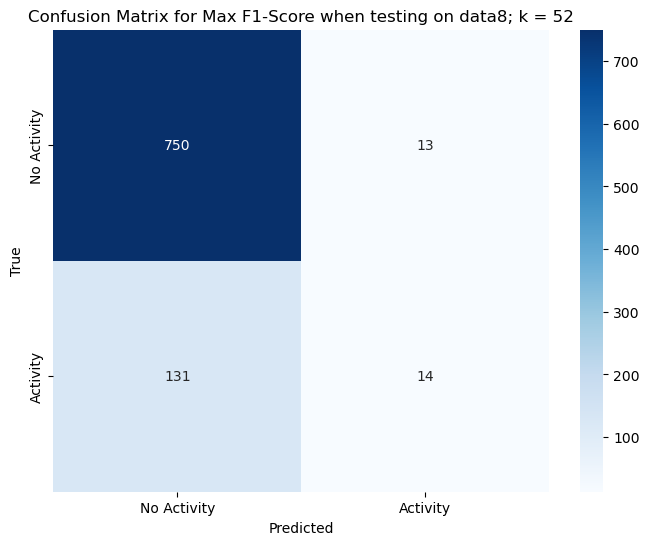

data8 has been tested on everyone


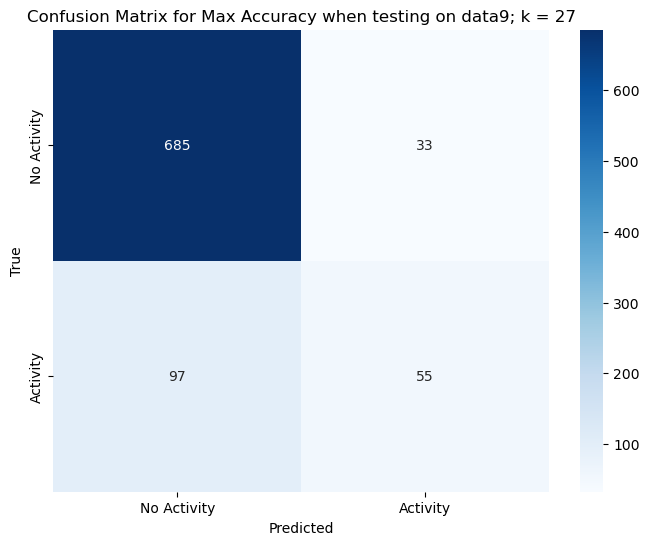

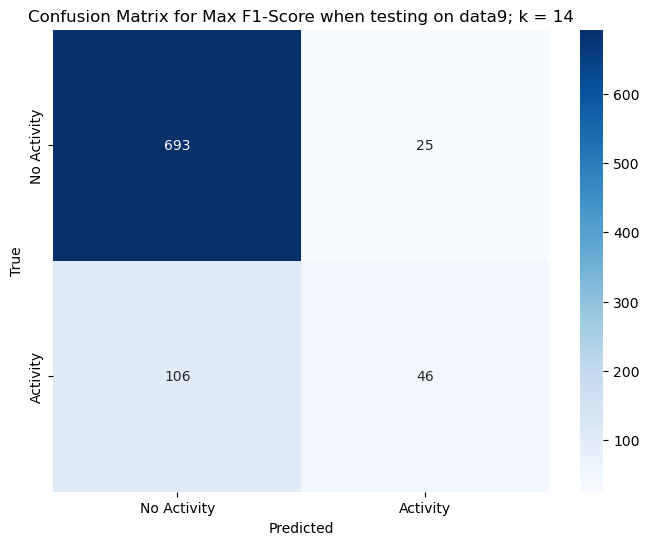

data9 has been tested on everyone


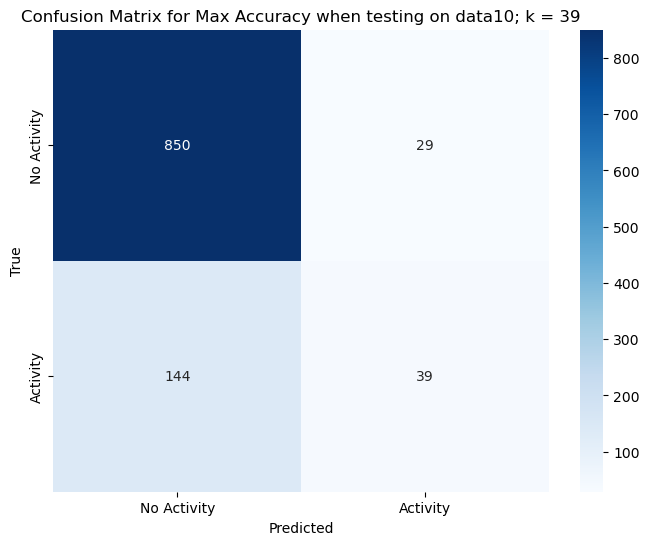

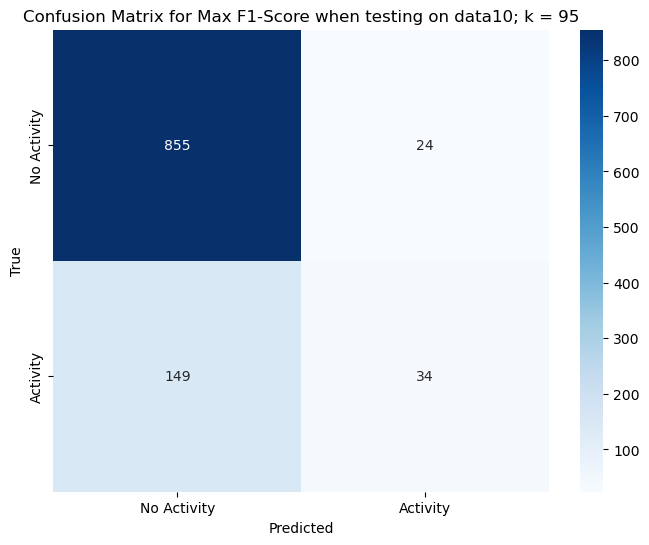

data10 has been tested on everyone


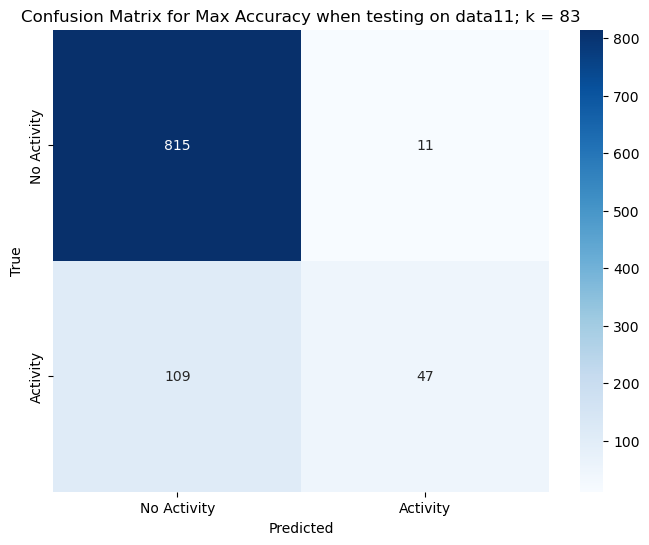

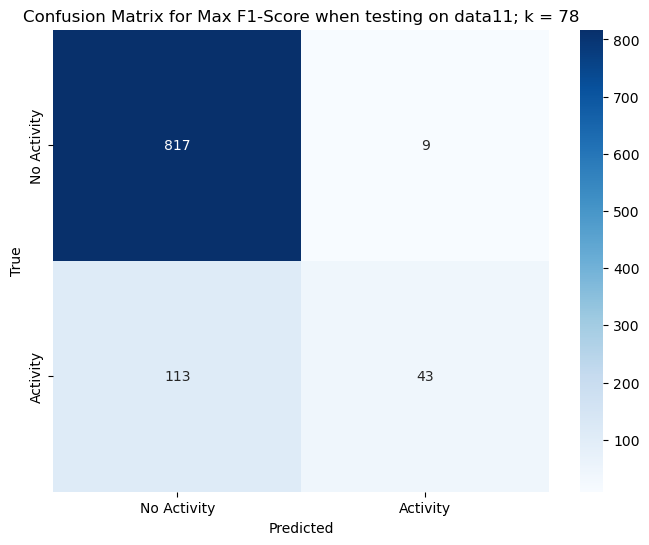

data11 has been tested on everyone


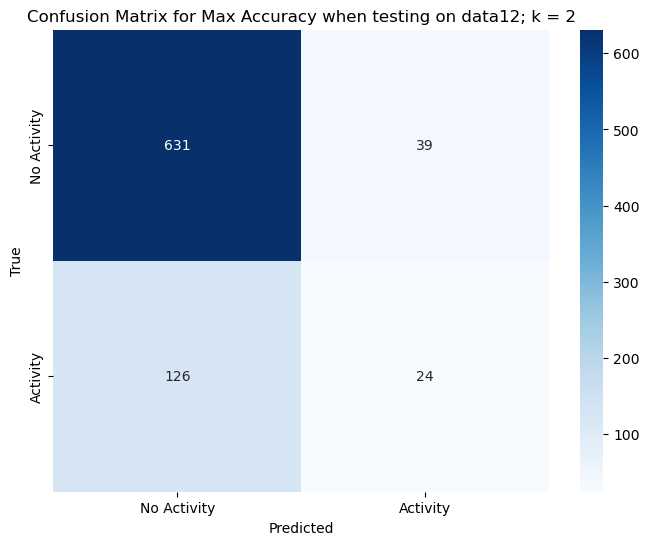

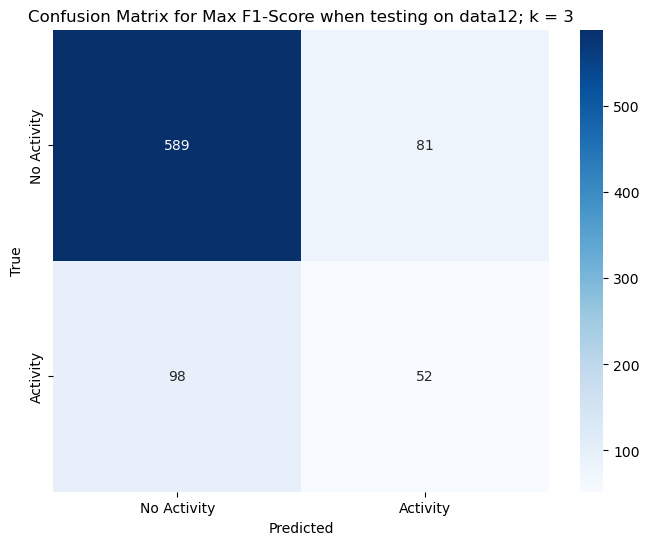

data12 has been tested on everyone


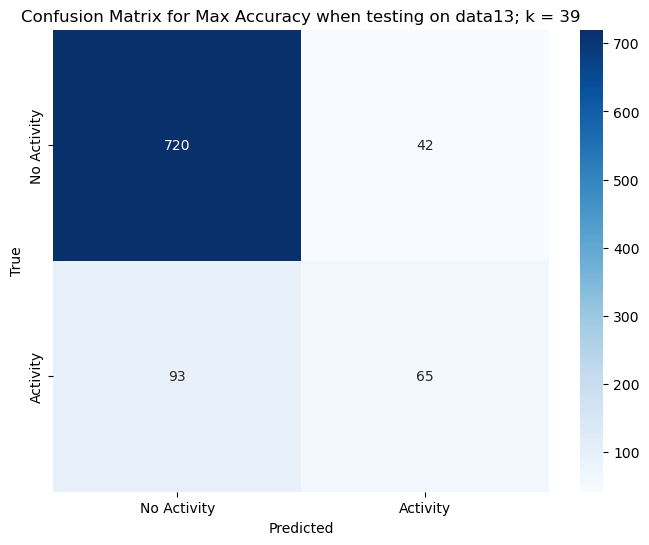

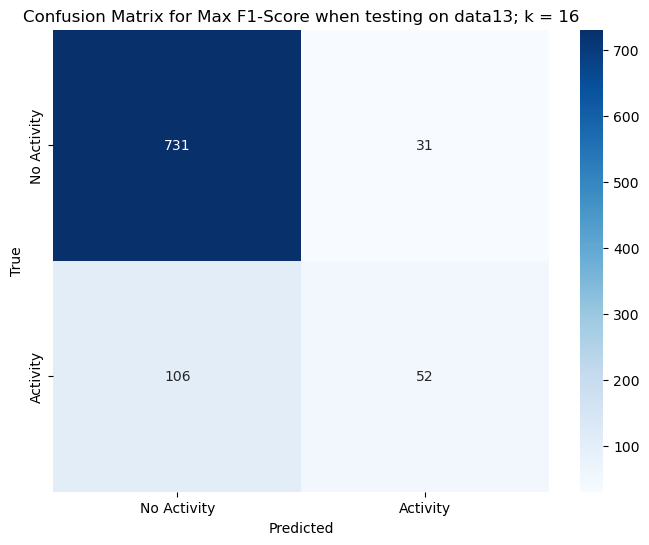

data13 has been tested on everyone


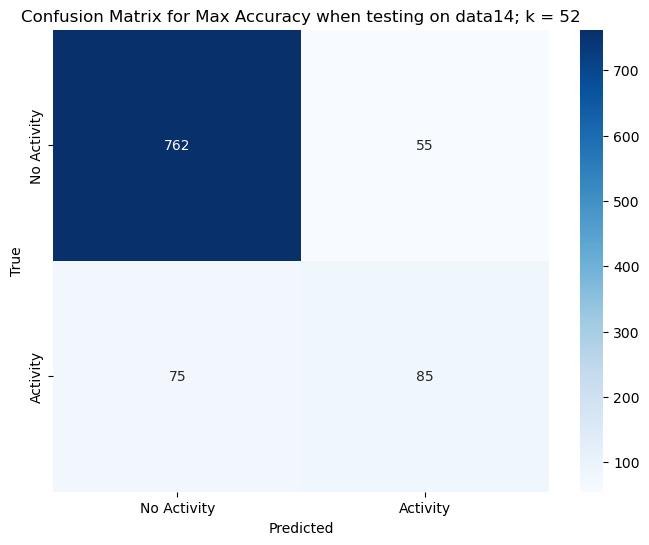

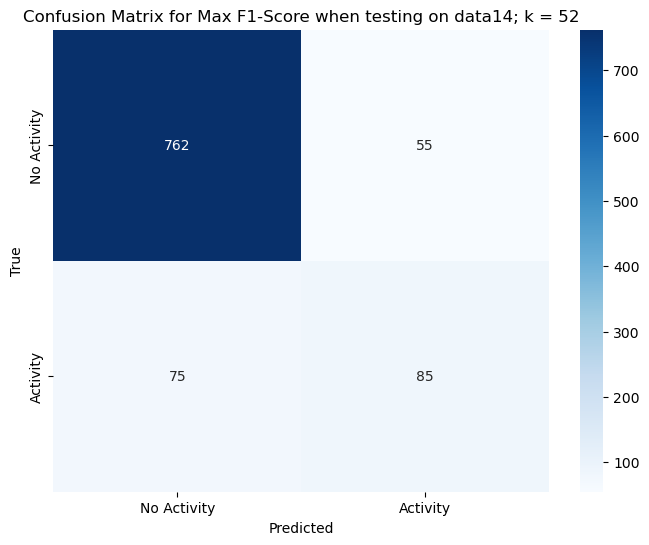

data14 has been tested on everyone


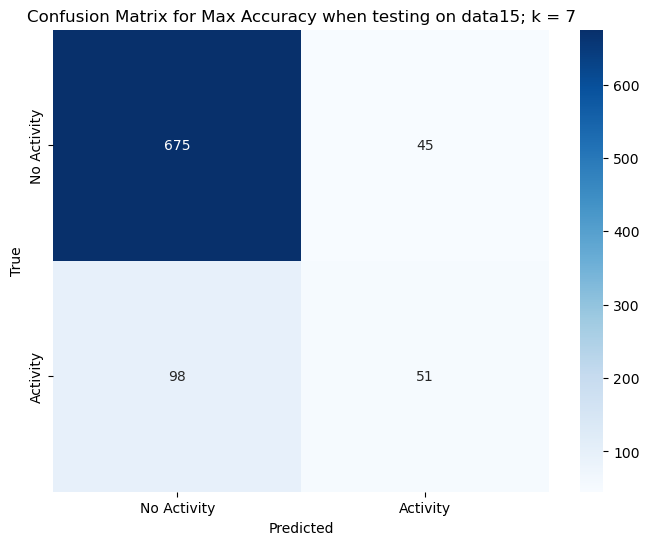

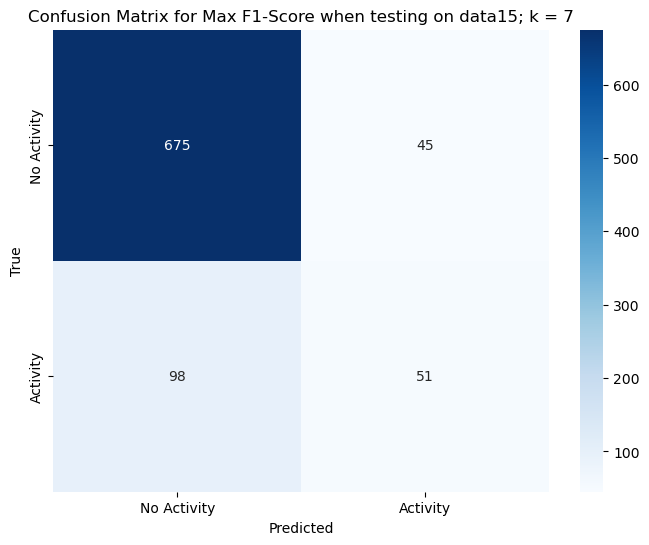

data15 has been tested on everyone


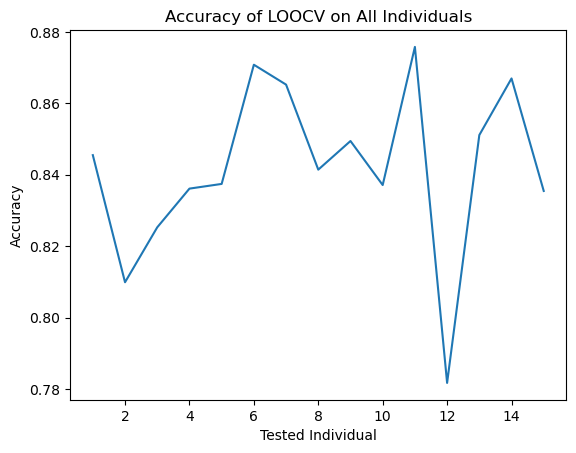

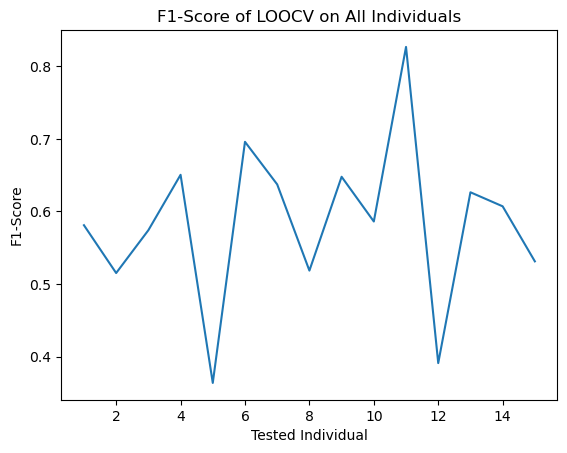

Average Accuracy:  0.841933949054877
Average F1-Score:  0.583567875161003


In [4]:
## ACC_specific_windowed_features.csv
## HR_specific_windowed_features.csv
## BVP_specific_windowed_features.csv
## 0: no_activity, baseline, clean_baseline, lunch, working, driving
## 1: stairs, soccer, cycling, walking

def uncorrelated(df, threshold=0.85, ignore_columns=None):
    if ignore_columns is None:
        ignore_columns = ["start_time", "end_time"]
    df_for_corr = data.drop(columns=ignore_columns, errors='ignore')
    corr_matrix = df_for_corr.corr(method='spearman').abs()
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    to_drop = [column for column in upper.columns if any(upper[column] > threshold)]
    filtered_columns = [col for col in data.columns if col not in to_drop]
    return filtered_columns

def remove_outliers(df, n_std=3):
    mask = pd.DataFrame(True, index=df.index, columns=df.columns)
    for col in df.columns:
        mean = df[col].mean()
        std = df[col].std()
        mask[col] = (df[col] >= mean - n_std*std) & (df[col] <= mean + n_std*std)
    return df[mask.all(axis=1)]

def remove_outliers_mad(df, n_mad=20):
    def mad(arr):
        med = np.median(arr)
        return np.median(np.abs(arr - med))
    
    mask = pd.DataFrame(True, index=df.index, columns=df.columns)
    for col in df.columns:
        median = df[col].median()
        mad_val = mad(df[col])
        mask[col] = (df[col] >= median - n_mad * mad_val) & (df[col] <= median + n_mad * mad_val)
    return df[mask.all(axis=1)]

dataframes = {}
for i in np.arange(1,16):
    name = f"data{i}"
    acc = pd.read_csv(f"HAR/ppg+dalia/data/PPG_FieldStudy/S{i}/S{i}_E4/ACC_specific_windowed_features.csv")
    hr = pd.read_csv(f"HAR/ppg+dalia/data/PPG_FieldStudy/S{i}/S{i}_E4/HR_specific_windowed_features.csv")
    bvp = pd.read_csv(f"HAR/ppg+dalia/data/PPG_FieldStudy/S{i}/S{i}_E4/BVP_specific_windowed_features.csv")
    acc['start_time'] = pd.to_datetime(acc['start_time'])
    hr['start_time'] = pd.to_datetime(hr['start_time'])
    bvp['start_time'] = pd.to_datetime(bvp['start_time'])
    acc['end_time'] = pd.to_datetime(acc['end_time'])
    hr['end_time'] = pd.to_datetime(hr['end_time'])
    bvp['end_time'] = pd.to_datetime(bvp['end_time'])

    common_columns = ['start_time', 'end_time', 'activity']
    data = acc.merge(hr, on=common_columns, how='inner').merge(bvp, on=common_columns, how='inner')
    allFeatures  = [col for col in data.columns if col not in ["start_time", "end_time"]]
    data = data[allFeatures]
    data.loc[data['activity'].isin([0, 1, 2, 7, 8, 9]), 'activity'] = 0
    data.loc[data['activity'].isin([3, 4, 5, 6]), 'activity'] = 1
    data = remove_outliers(data)
    dataframes[name] = data

LOOCVAccuracy = np.array([])
LOOCVf1_score = np.array([])
for tester in dataframes:
    trainingFeatures  = [col for col in dataframes[tester].columns if col not in ["activity", "start_time", "end_time"]]
    
    testingFeatures = dataframes[tester][trainingFeatures].to_numpy()
    testingActivity = dataframes[tester]["activity"].to_numpy()
    
    X_train = pd.DataFrame()
    y_train = pd.DataFrame()
    for trainer in dataframes:
        if trainer != tester:
            X_train = pd.concat([X_train, dataframes[trainer][trainingFeatures]], ignore_index=True)
            y_train = pd.concat([y_train, dataframes[trainer]["activity"]], ignore_index=True)

    X_train = X_train.to_numpy()
    y_train = y_train.to_numpy().flatten()
    
    testingFeatures = StandardScaler().fit_transform(testingFeatures)
    X_train = StandardScaler().fit_transform(X_train)

    
    k = np.arange(1,100)
    accuracy = np.array([])
    f1score = np.array([])
    maxAccK = 0
    maxF1K = 0
    maxAcc = 0
    maxF1 = 0
    for i in k:
        knn = KNeighborsClassifier(i)
        knn.fit(X_train, y_train)
        acc = (accuracy_score(testingActivity, knn.predict(testingFeatures)))
        f1 = precision_score(testingActivity, knn.predict(testingFeatures))
        accuracy = np.append(accuracy, acc)
        f1score = np.append(f1score, f1)
        if acc > maxAcc:
            maxAccK = i
            maxAcc = acc
        if f1 > maxF1:
            maxF1K = i
            maxF1 = f1


    knn = KNeighborsClassifier(maxAccK)
    knn.fit(X_train, y_train)

    y_pred = knn.predict(testingFeatures)
    cmat = confusion_matrix(testingActivity, y_pred) #validate model predictions with actual y values
    labels = ["No Activity", "Activity"]

    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cmat, annot=True, cmap="Blues", fmt="d", xticklabels=labels, yticklabels=labels)
    
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f"Confusion Matrix for Max Accuracy when testing on {tester}; k = {maxAccK}")
    plt.show()
    
    knn = KNeighborsClassifier(maxF1K)
    knn.fit(X_train, y_train)

    y_pred = knn.predict(testingFeatures)
    cmat = confusion_matrix(testingActivity, y_pred) #validate model predictions with actual y values
    labels = ["No Activity", "Activity"]

    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cmat, annot=True, cmap="Blues", fmt="d", xticklabels=labels, yticklabels=labels)
    
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f"Confusion Matrix for Max F1-Score when testing on {tester}; k = {maxF1K}")
    plt.show()
    
    LOOCVAccuracy = np.append(LOOCVAccuracy, accuracy_score(testingActivity, y_pred))
    LOOCVf1_score = np.append(LOOCVf1_score, precision_score(testingActivity, y_pred))
    
    print(f"{tester} has been tested on everyone")

plt.plot(np.arange(1,16), LOOCVAccuracy)
plt.title("Accuracy of LOOCV on All Individuals")
plt.xlabel("Tested Individual")
plt.ylabel("Accuracy")
plt.show()

plt.plot(np.arange(1,16), LOOCVf1_score)
plt.title("F1-Score of LOOCV on All Individuals")
plt.xlabel("Tested Individual")
plt.ylabel("F1-Score")
plt.show()

print("Average Accuracy: ", sum(LOOCVAccuracy) / len(LOOCVAccuracy))
print("Average F1-Score: ", sum(LOOCVf1_score) / len(LOOCVf1_score))


In [25]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA


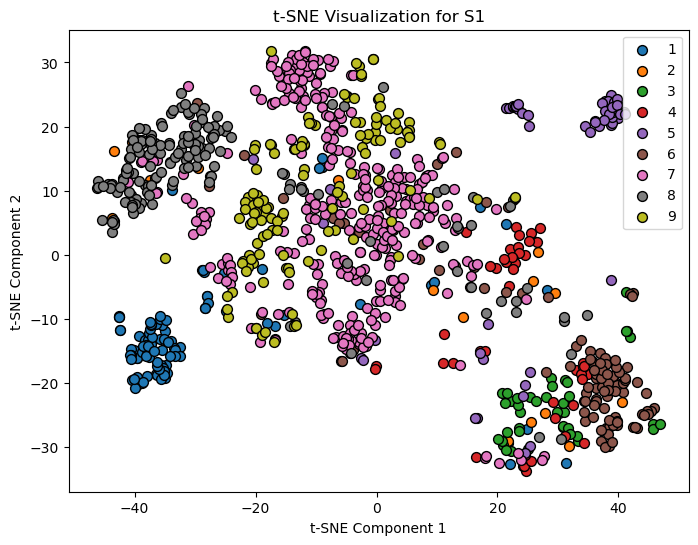

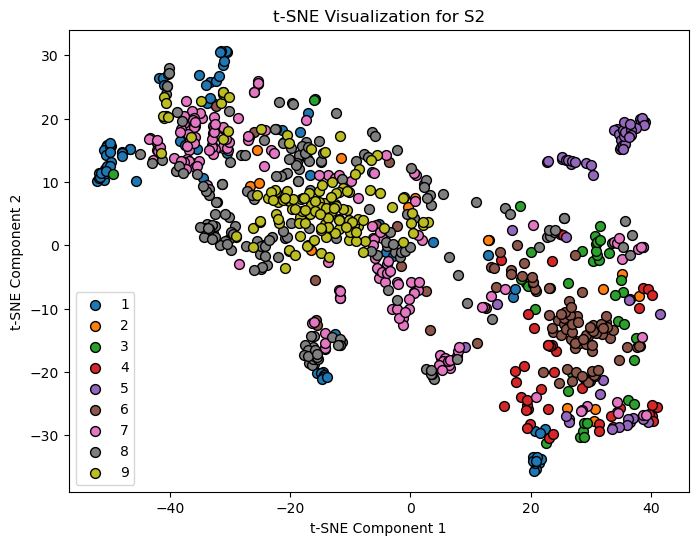

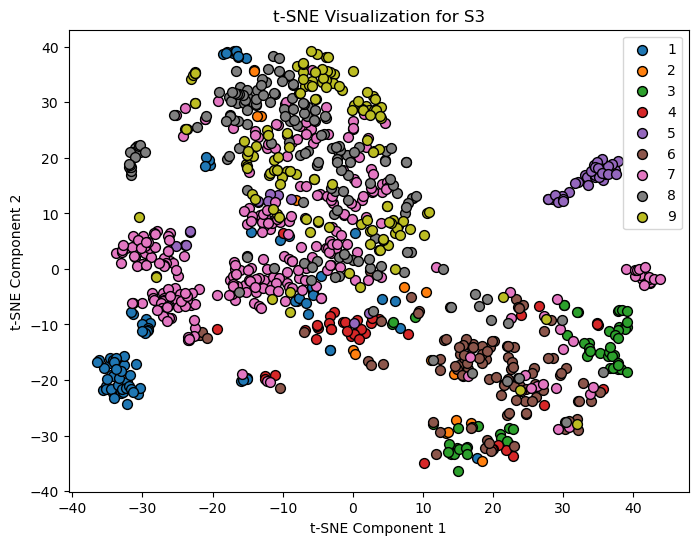

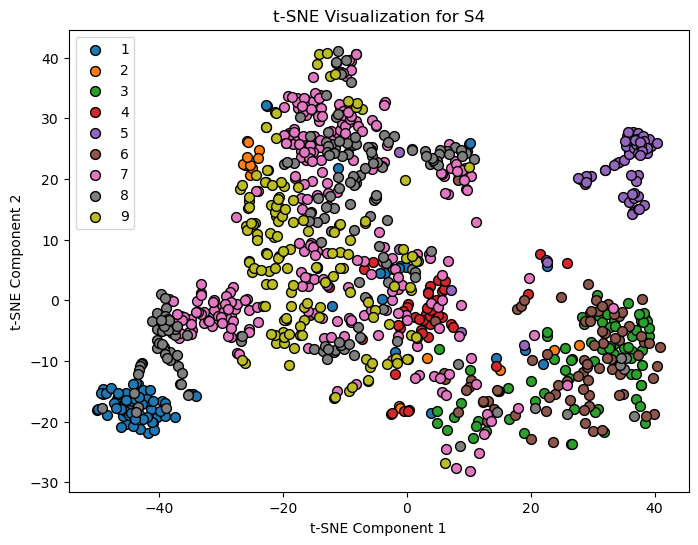

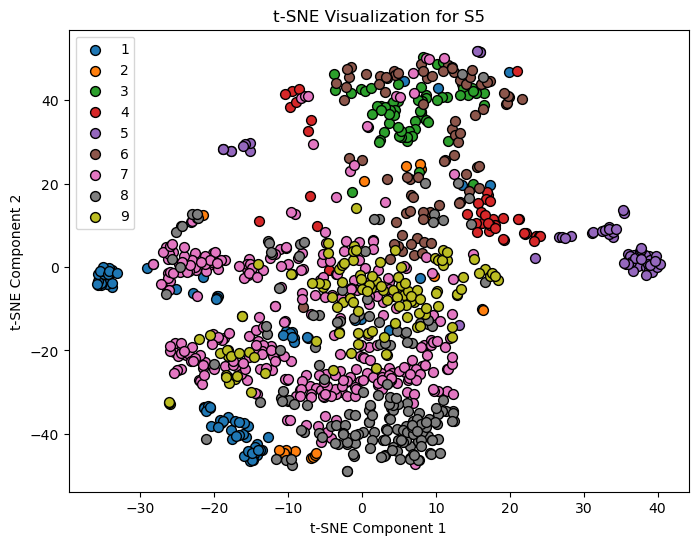

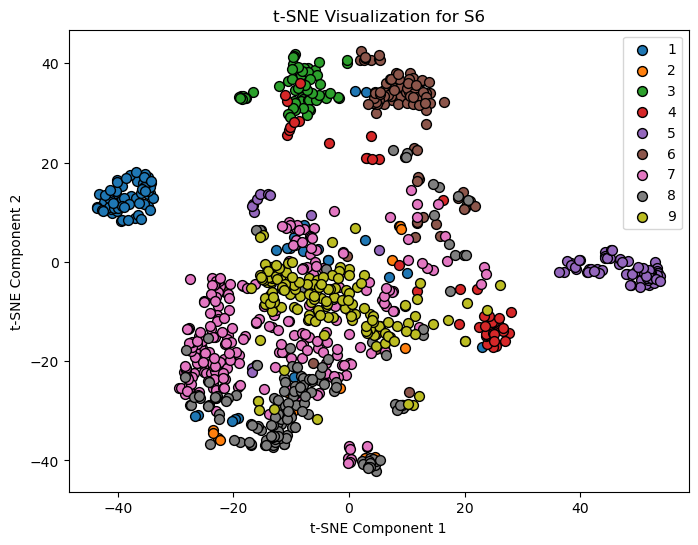

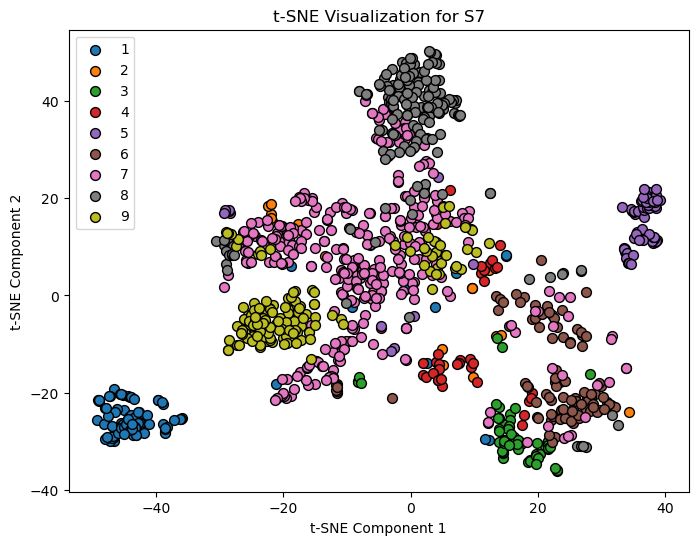

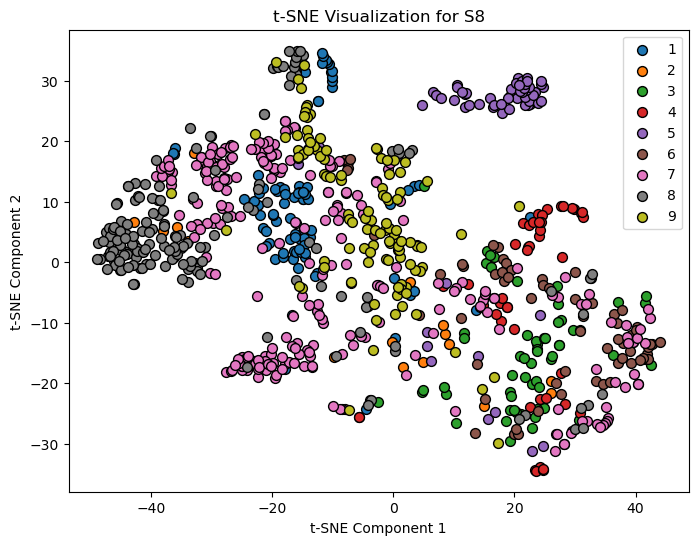

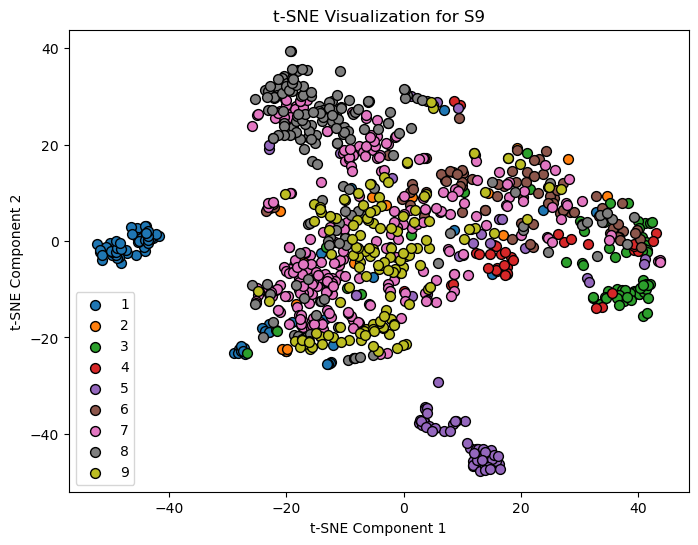

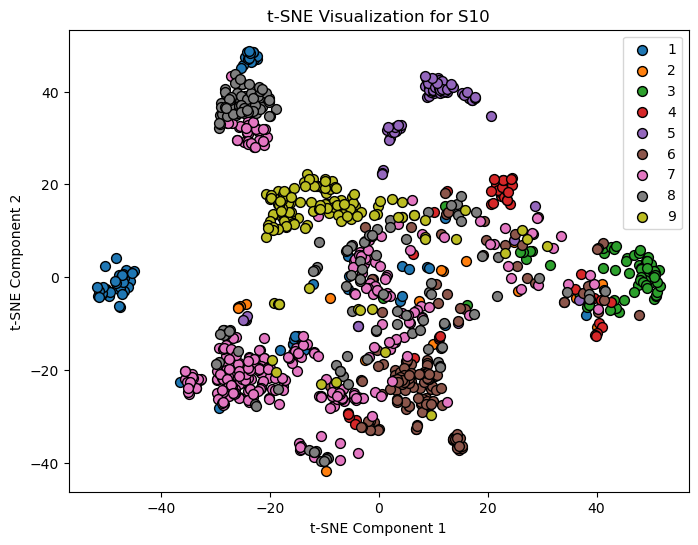

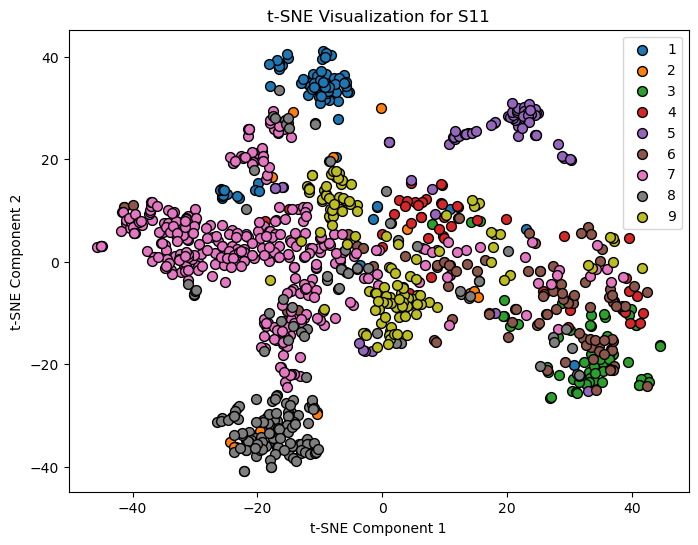

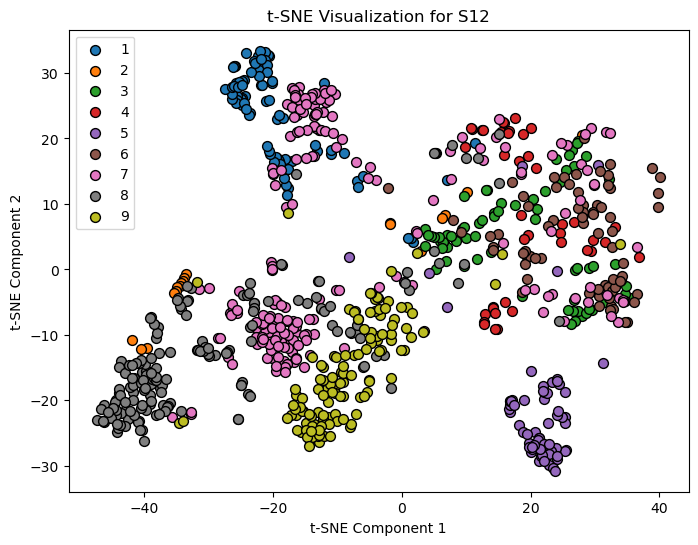

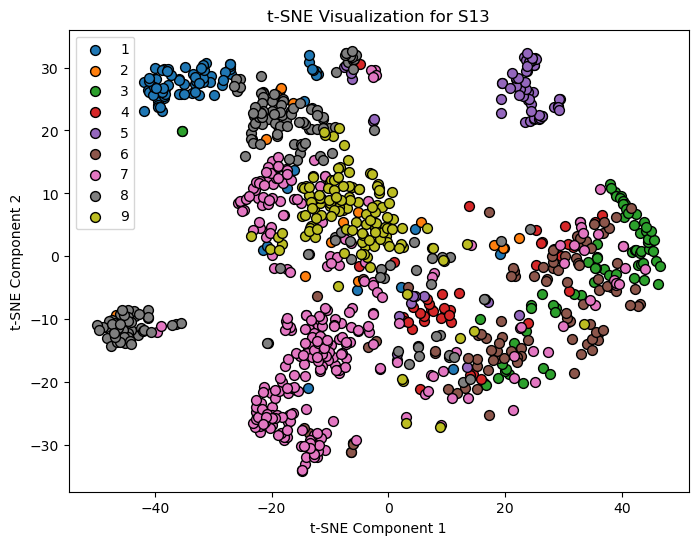

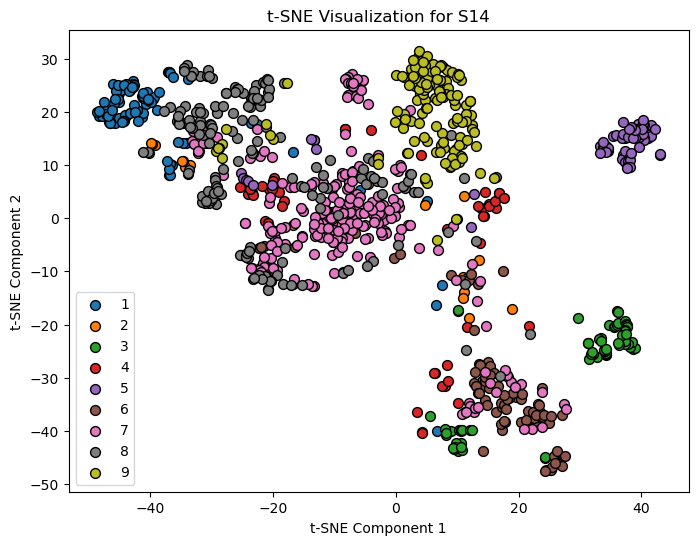

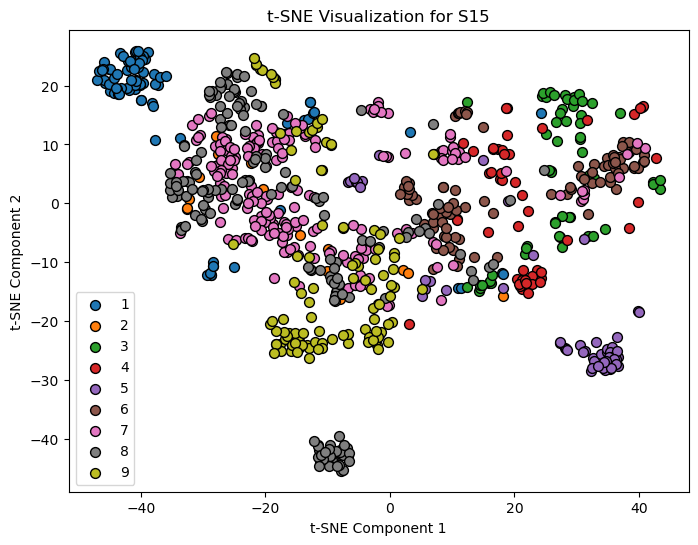

In [42]:
for i in np.arange(1,16):
    acc = pd.read_csv(f"HAR/ppg+dalia/data/PPG_FieldStudy/S{i}/S{i}_E4/ACC_specific_windowed_features.csv")
    hr = pd.read_csv(f"HAR/ppg+dalia/data/PPG_FieldStudy/S{i}/S{i}_E4/HR_specific_windowed_features.csv")
    bvp = pd.read_csv(f"HAR/ppg+dalia/data/PPG_FieldStudy/S{i}/S{i}_E4/BVP_specific_windowed_features.csv")
    acc['start_time'] = pd.to_datetime(acc['start_time'])
    hr['start_time'] = pd.to_datetime(hr['start_time'])
    bvp['start_time'] = pd.to_datetime(bvp['start_time'])
    acc['end_time'] = pd.to_datetime(acc['end_time'])
    hr['end_time'] = pd.to_datetime(hr['end_time'])
    bvp['end_time'] = pd.to_datetime(bvp['end_time'])

    common_columns = ['start_time', 'end_time', 'activity']
    data = acc.merge(hr, on=common_columns, how='inner').merge(bvp, on=common_columns, how='inner')
    allFeatures  = [col for col in data.columns if col not in ["start_time", "end_time"]]
    data = data[allFeatures]

    y = data.pop('activity')

    X_scaled = StandardScaler().fit_transform(data)

    tsne = TSNE(n_components=2)
    X_tsne = tsne.fit_transform(X_scaled)

    # Plot the t-SNE result
    plt.figure(figsize=(8, 6))

    for j in np.unique(y):
        if j != 0:
            plt.scatter(X_tsne[y == j, 0], X_tsne[y == j, 1], label=f'{j}', edgecolor='k', s=50)

    plt.title(f't-SNE Visualization for S{i}')
    plt.xlabel('t-SNE Component 1')
    plt.ylabel('t-SNE Component 2')
    plt.legend()
    plt.show()
